# Design of Experiments: Master Comparison - Balance Validation Across All Methods

## Introduction

This comprehensive notebook compares all Design of Experiments (DOE) methods covered in this series:

1. **Sampling Methods**: Simple Random, Stratified
2. **Classical Designs**: CRD, RBD, Latin Square
3. **Factorial Designs**: Full Factorial, Fractional Factorial
4. **Response Surface Methods**: CCD, Box-Behnken
5. **Optimal Designs**: D-Optimal, A-Optimal, G-Optimal, I-Optimal

We'll evaluate each method on:
- **Balance Achievement**: How well treatment/control groups are balanced
- **Statistical Power**: Ability to detect true effects
- **Efficiency**: Information gained per experimental run
- **Practical Considerations**: Ease of implementation, constraints handling

In [5]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from pyDOE3 import fullfact, fracfact, ccdesign, bbdesign
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("\nReady for comprehensive DOE comparison!")

Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3

Ready for comprehensive DOE comparison!


## 1. Load and Prepare Comprehensive Dataset

In [6]:
# Load the e-commerce dataset
data = pd.read_csv('DOE_Simulator/data/raw/ecommerce_data.csv')

# Add all necessary columns if not present
if 'age' not in data.columns:
    data['age'] = np.random.uniform(18, 65, len(data))
if 'income' not in data.columns:
    data['income'] = np.random.lognormal(10.5, 0.5, len(data))  # Log-normal income distribution
if 'previous_purchases' not in data.columns:
    data['previous_purchases'] = np.random.poisson(5, len(data))
if 'device_type' not in data.columns:
    data['device_type'] = np.random.choice(['Mobile', 'Desktop', 'Tablet'], 
                                          len(data), p=[0.5, 0.4, 0.1])
if 'customer_segment' not in data.columns:
    data['customer_segment'] = np.random.choice(['New', 'Regular', 'Premium'], 
                                               len(data), p=[0.3, 0.5, 0.2])
if 'region' not in data.columns:
    data['region'] = np.random.choice(['North', 'South', 'East', 'West'], len(data))

# Create outcome variable
def generate_outcome(row):
    """Generate realistic outcome based on multiple factors"""
    base_conversion = 0.1
    
    # Age effect (peak at 35)
    age_effect = -0.001 * (row['age'] - 35)**2 + 0.05
    
    # Income effect (log scale)
    income_effect = 0.02 * np.log(row['income'] / 10000)
    
    # Previous purchases effect
    purchase_effect = 0.01 * min(row['previous_purchases'], 10)
    
    # Device effect
    device_effects = {'Mobile': 0.02, 'Desktop': 0.05, 'Tablet': 0.03}
    device_effect = device_effects.get(row['device_type'], 0)
    
    # Segment effect
    segment_effects = {'New': -0.02, 'Regular': 0.03, 'Premium': 0.08}
    segment_effect = segment_effects.get(row['customer_segment'], 0)
    
    # Calculate probability
    prob = base_conversion + age_effect + income_effect + purchase_effect + \
           device_effect + segment_effect
    
    # Add noise and ensure valid probability
    prob += np.random.normal(0, 0.02)
    prob = max(0, min(1, prob))
    
    return np.random.binomial(1, prob)

data['converted'] = data.apply(generate_outcome, axis=1)

print("Dataset Overview:")
print(f"Shape: {data.shape}")
print(f"\nColumns: {', '.join(data.columns.tolist())}")
print(f"\nConversion Rate: {data['converted'].mean():.2%}")
print(f"\nNumeric columns summary:")
print(data[['age', 'income', 'previous_purchases']].describe().round(2))

Dataset Overview:
Shape: (20000, 30)

Columns: customer_id, age, gender, location, income_level, education, account_age_days, total_orders, avg_order_value, last_order_days_ago, product_category_preference, email_open_rate, website_visits_per_month, mobile_app_user, loyalty_program_member, customer_service_interactions, cart_abandonment_rate, review_count, avg_rating_given, social_media_follower, conversion_rate, lifetime_value, churn_probability, response_to_marketing, income, previous_purchases, device_type, customer_segment, region, converted

Conversion Rate: 17.18%

Numeric columns summary:
            age     income  previous_purchases
count  20000.00   20000.00            20000.00
mean      37.84   41293.81                4.99
std       11.46   22134.43                2.23
min       18.00    5109.21                0.00
25%       30.00   26026.27                3.00
50%       38.00   36455.60                5.00
75%       46.00   51070.05                6.00
max       75.00  3409

## 2. Balance Validation Framework

We'll create a comprehensive framework to evaluate balance across all methods.

In [7]:
class BalanceValidator:
    """Comprehensive balance validation for experimental designs"""
    
    def __init__(self, data):
        self.data = data
        self.numeric_cols = ['age', 'income', 'previous_purchases']
        self.categorical_cols = ['device_type', 'customer_segment', 'region']
    
    def calculate_standardized_difference(self, treatment, control, variable):
        """Calculate standardized difference (Cohen's d) for a variable"""
        if variable in self.numeric_cols:
            # Numeric variable
            mean_t = treatment[variable].mean()
            mean_c = control[variable].mean()
            var_t = treatment[variable].var()
            var_c = control[variable].var()
            n_t = len(treatment)
            n_c = len(control)
            
            # Pooled standard deviation
            pooled_std = np.sqrt(((n_t - 1) * var_t + (n_c - 1) * var_c) / (n_t + n_c - 2))
            
            if pooled_std == 0:
                return 0
            
            std_diff = (mean_t - mean_c) / pooled_std
        else:
            # Categorical variable - use proportion difference
            prop_t = treatment[variable].value_counts(normalize=True)
            prop_c = control[variable].value_counts(normalize=True)
            
            # Maximum absolute difference across categories
            all_categories = set(prop_t.index) | set(prop_c.index)
            max_diff = 0
            for cat in all_categories:
                p_t = prop_t.get(cat, 0)
                p_c = prop_c.get(cat, 0)
                diff = abs(p_t - p_c)
                max_diff = max(max_diff, diff)
            
            std_diff = max_diff
        
        return abs(std_diff)
    
    def validate_balance(self, treatment_indices, control_indices, method_name="Method"):
        """Validate balance between treatment and control groups"""
        treatment = self.data.iloc[treatment_indices]
        control = self.data.iloc[control_indices]
        
        results = {
            'method': method_name,
            'n_treatment': len(treatment),
            'n_control': len(control),
            'balance_scores': {}
        }
        
        # Calculate balance for each variable
        for var in self.numeric_cols + self.categorical_cols:
            std_diff = self.calculate_standardized_difference(treatment, control, var)
            results['balance_scores'][var] = std_diff
        
        # Overall balance metrics
        all_scores = list(results['balance_scores'].values())
        results['mean_std_diff'] = np.mean(all_scores)
        results['max_std_diff'] = np.max(all_scores)
        results['balance_quality'] = self._classify_balance(results['mean_std_diff'])
        
        # Statistical tests
        results['statistical_tests'] = self._perform_statistical_tests(treatment, control)
        
        return results
    
    def _classify_balance(self, mean_std_diff):
        """Classify balance quality based on standardized difference"""
        if mean_std_diff < 0.1:
            return "Excellent"
        elif mean_std_diff < 0.25:
            return "Good"
        elif mean_std_diff < 0.5:
            return "Moderate"
        else:
            return "Poor"
    
    def _perform_statistical_tests(self, treatment, control):
        """Perform statistical tests for balance"""
        tests = {}
        
        # T-tests for numeric variables
        for var in self.numeric_cols:
            _, p_value = stats.ttest_ind(treatment[var], control[var])
            tests[f'{var}_pvalue'] = p_value
        
        # Chi-square tests for categorical variables
        for var in self.categorical_cols:
            contingency = pd.crosstab(pd.concat([treatment, control])[var],
                                     pd.Series(['T'] * len(treatment) + ['C'] * len(control)))
            _, p_value, _, _ = stats.chi2_contingency(contingency)
            tests[f'{var}_pvalue'] = p_value
        
        return tests
    
    def visualize_balance(self, results_list):
        """Create comprehensive balance visualization"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Extract data for plotting
        methods = [r['method'] for r in results_list]
        mean_diffs = [r['mean_std_diff'] for r in results_list]
        max_diffs = [r['max_std_diff'] for r in results_list]
        
        # Plot 1: Overall balance comparison
        ax1 = axes[0, 0]
        x = np.arange(len(methods))
        width = 0.35
        ax1.bar(x - width/2, mean_diffs, width, label='Mean Std Diff', color='steelblue')
        ax1.bar(x + width/2, max_diffs, width, label='Max Std Diff', color='coral')
        ax1.axhline(y=0.1, color='g', linestyle='--', label='Excellent threshold')
        ax1.axhline(y=0.25, color='y', linestyle='--', label='Good threshold')
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Standardized Difference')
        ax1.set_title('Overall Balance Comparison')
        ax1.set_xticks(x)
        ax1.set_xticklabels(methods, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Variable-specific balance heatmap
        ax2 = axes[0, 1]
        balance_matrix = []
        for r in results_list:
            row = [r['balance_scores'][var] for var in self.numeric_cols + self.categorical_cols]
            balance_matrix.append(row)
        
        im = ax2.imshow(np.array(balance_matrix).T, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.5)
        ax2.set_xticks(np.arange(len(methods)))
        ax2.set_xticklabels(methods, rotation=45, ha='right')
        ax2.set_yticks(np.arange(len(self.numeric_cols + self.categorical_cols)))
        ax2.set_yticklabels(self.numeric_cols + self.categorical_cols)
        ax2.set_title('Balance Heatmap (lower is better)')
        plt.colorbar(im, ax=ax2)
        
        # Plot 3: Sample size comparison
        ax3 = axes[1, 0]
        n_treatment = [r['n_treatment'] for r in results_list]
        n_control = [r['n_control'] for r in results_list]
        ax3.bar(x - width/2, n_treatment, width, label='Treatment', color='lightblue')
        ax3.bar(x + width/2, n_control, width, label='Control', color='lightcoral')
        ax3.set_xlabel('Method')
        ax3.set_ylabel('Sample Size')
        ax3.set_title('Sample Size Distribution')
        ax3.set_xticks(x)
        ax3.set_xticklabels(methods, rotation=45, ha='right')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Balance quality distribution
        ax4 = axes[1, 1]
        quality_counts = pd.Series([r['balance_quality'] for r in results_list]).value_counts()
        colors = {'Excellent': 'green', 'Good': 'yellow', 'Moderate': 'orange', 'Poor': 'red'}
        ax4.pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%',
               colors=[colors.get(q, 'gray') for q in quality_counts.index])
        ax4.set_title('Balance Quality Distribution')
        
        plt.suptitle('Comprehensive Balance Analysis Across DOE Methods', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Initialize validator
validator = BalanceValidator(data)
print("Balance Validator initialized successfully!")

Balance Validator initialized successfully!


## 3. Implement All DOE Methods

In [8]:
def implement_all_methods(data, sample_size=100):
    """Implement all DOE methods and return assignments"""
    
    results = {}
    n = len(data)
    
    # 1. Simple Random Sampling
    random_indices = np.random.choice(n, size=min(sample_size*2, n), replace=False)
    np.random.shuffle(random_indices)
    split = len(random_indices) // 2
    results['Simple Random'] = {
        'treatment': random_indices[:split],
        'control': random_indices[split:]
    }
    
    # 2. Stratified Sampling
    strata = data.groupby('customer_segment').groups
    strat_treatment = []
    strat_control = []
    for segment, indices in strata.items():
        segment_sample = np.random.choice(indices, 
                                        size=min(len(indices), sample_size*2//3), 
                                        replace=False)
        np.random.shuffle(segment_sample)
        split = len(segment_sample) // 2
        strat_treatment.extend(segment_sample[:split])
        strat_control.extend(segment_sample[split:])
    
    results['Stratified'] = {
        'treatment': np.array(strat_treatment),
        'control': np.array(strat_control)
    }
    
    # 3. Completely Randomized Design (CRD)
    crd_indices = np.random.choice(n, size=min(sample_size*2, n), replace=False)
    treatments = np.random.choice([0, 1], size=len(crd_indices))
    results['CRD'] = {
        'treatment': crd_indices[treatments == 1],
        'control': crd_indices[treatments == 0]
    }
    
    # 4. Randomized Block Design (RBD)
    # Block by region
    blocks = data.groupby('region').groups
    rbd_treatment = []
    rbd_control = []
    for region, indices in blocks.items():
        block_sample = np.random.choice(indices, 
                                      size=min(len(indices), sample_size//2), 
                                      replace=False)
        np.random.shuffle(block_sample)
        split = len(block_sample) // 2
        rbd_treatment.extend(block_sample[:split])
        rbd_control.extend(block_sample[split:])
    
    results['RBD'] = {
        'treatment': np.array(rbd_treatment),
        'control': np.array(rbd_control)
    }
    
    # 5. Latin Square (simplified for demonstration)
    # Use first 16 observations for 4x4 Latin Square
    latin_size = 16
    latin_indices = np.random.choice(n, size=min(latin_size, n), replace=False)
    # Simple treatment assignment for Latin Square
    latin_treatment = latin_indices[::2]
    latin_control = latin_indices[1::2]
    
    results['Latin Square'] = {
        'treatment': latin_treatment,
        'control': latin_control
    }
    
    # 6. Full Factorial (2^3 design)
    # Create factorial structure
    factorial_design = fullfact([2, 2, 2])  # 3 factors, 2 levels each
    n_factorial = len(factorial_design)
    factorial_indices = np.random.choice(n, size=min(n_factorial*4, n), replace=False)
    
    # Assign based on first factor
    treatment_mask = np.tile(factorial_design[:, 0] == 1, 4)[:len(factorial_indices)]
    results['Full Factorial'] = {
        'treatment': factorial_indices[treatment_mask],
        'control': factorial_indices[~treatment_mask]
    }
    
    # 7. Fractional Factorial (2^(3-1) design)
    frac_design = fracfact('a b ab')  # 2^(3-1) design
    n_frac = len(frac_design)
    frac_indices = np.random.choice(n, size=min(n_frac*8, n), replace=False)
    
    # Assign based on first factor
    frac_treatment_mask = np.tile(frac_design[:, 0] == 1, 8)[:len(frac_indices)]
    results['Fractional Factorial'] = {
        'treatment': frac_indices[frac_treatment_mask],
        'control': frac_indices[~frac_treatment_mask]
    }
    
    # 8. Central Composite Design
    ccd = ccdesign(2, center=(2, 2))  # 2 factors
    n_ccd = len(ccd)
    ccd_indices = np.random.choice(n, size=min(n_ccd*2, n), replace=False)
    
    # Split randomly for CCD
    np.random.shuffle(ccd_indices)
    split = len(ccd_indices) // 2
    results['CCD'] = {
        'treatment': ccd_indices[:split],
        'control': ccd_indices[split:]
    }
    
    # 9. Box-Behnken Design
    bb = bbdesign(3, center=1)  # 3 factors
    n_bb = len(bb)
    bb_indices = np.random.choice(n, size=min(n_bb*2, n), replace=False)
    
    # Split for Box-Behnken
    np.random.shuffle(bb_indices)
    split = len(bb_indices) // 2
    results['Box-Behnken'] = {
        'treatment': bb_indices[:split],
        'control': bb_indices[split:]
    }
    
    # 10. D-Optimal (simplified implementation)
    # Select points that maximize information
    # For simplicity, use stratified sampling with optimization
    numeric_data = data[['age', 'income', 'previous_purchases']].values
    
    # K-means clustering for D-optimal selection
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=min(20, sample_size//5), random_state=42)
    clusters = kmeans.fit_predict(numeric_data)
    
    d_optimal_treatment = []
    d_optimal_control = []
    for cluster in np.unique(clusters):
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) >= 2:
            selected = np.random.choice(cluster_indices, 
                                      size=min(2, len(cluster_indices)), 
                                      replace=False)
            d_optimal_treatment.append(selected[0])
            if len(selected) > 1:
                d_optimal_control.append(selected[1])
    
    results['D-Optimal'] = {
        'treatment': np.array(d_optimal_treatment),
        'control': np.array(d_optimal_control)
    }
    
    return results

# Implement all methods
all_methods = implement_all_methods(data, sample_size=100)

print("All DOE methods implemented successfully!")
print("\nSample sizes per method:")
for method, assignments in all_methods.items():
    n_t = len(assignments['treatment'])
    n_c = len(assignments['control'])
    print(f"  {method:20s}: Treatment={n_t:3d}, Control={n_c:3d}, Total={n_t+n_c:3d}")

All DOE methods implemented successfully!

Sample sizes per method:
  Simple Random       : Treatment=100, Control=100, Total=200
  Stratified          : Treatment= 99, Control= 99, Total=198
  CRD                 : Treatment= 84, Control=116, Total=200
  RBD                 : Treatment=100, Control=100, Total=200
  Latin Square        : Treatment=  8, Control=  8, Total= 16
  Full Factorial      : Treatment= 16, Control= 16, Total= 32
  Fractional Factorial: Treatment= 16, Control= 16, Total= 32
  CCD                 : Treatment= 12, Control= 12, Total= 24
  Box-Behnken         : Treatment= 13, Control= 13, Total= 26
  D-Optimal           : Treatment= 19, Control= 19, Total= 38


In [10]:
def _perform_statistical_tests(self, treatment, control):
    """Perform statistical tests for balance"""
    tests = {}
    
    # T-tests for numeric variables
    for var in self.numeric_cols:
        try:
            if len(treatment[var]) > 0 and len(control[var]) > 0:
                _, p_value = stats.ttest_ind(treatment[var], control[var])
                tests[f'{var}_pvalue'] = p_value
            else:
                tests[f'{var}_pvalue'] = np.nan
        except Exception as e:
            tests[f'{var}_pvalue'] = np.nan
    
    # Chi-square tests for categorical variables
    for var in self.categorical_cols:
        try:
            # Check if both groups have data
            if len(treatment) == 0 or len(control) == 0:
                tests[f'{var}_pvalue'] = np.nan
                continue
            
            # Create contingency table with proper indices
            combined = pd.concat([treatment[[var]], control[[var]]], 
                                keys=['T', 'C'], 
                                ignore_index=False)
            
            # Create group labels
            group = ['T'] * len(treatment) + ['C'] * len(control)
            
            # Build contingency table
            contingency = pd.crosstab(combined[var], group)
            
            # Check if contingency table has data
            if contingency.size == 0 or contingency.sum().sum() == 0:
                tests[f'{var}_pvalue'] = np.nan
                continue
            
            # Check for minimum cell frequencies
            if (contingency.values < 5).any():
                # Use Fisher's exact test for small samples (if 2x2)
                if contingency.shape == (2, 2):
                    from scipy.stats import fisher_exact
                    _, p_value = fisher_exact(contingency)
                else:
                    # For larger tables with small cells, still use chi-square with warning
                    _, p_value, _, _ = stats.chi2_contingency(contingency)
            else:
                _, p_value, _, _ = stats.chi2_contingency(contingency)
            
            tests[f'{var}_pvalue'] = p_value
            
        except Exception as e:
            # If any error occurs, set p-value to NaN
            tests[f'{var}_pvalue'] = np.nan
            print(f"Warning: Could not compute test for {var}: {str(e)}")
    
    return tests

In [11]:
def implement_all_methods(data, sample_size=100):
    """Implement all DOE methods and return assignments"""
    
    results = {}
    n = len(data)
    
    # Ensure minimum sample size
    min_sample_per_group = 10
    sample_size = max(sample_size, min_sample_per_group * 2)
    
    # 1. Simple Random Sampling
    try:
        random_indices = np.random.choice(n, size=min(sample_size*2, n), replace=False)
        np.random.shuffle(random_indices)
        split = len(random_indices) // 2
        
        # Ensure minimum size per group
        if split >= min_sample_per_group:
            results['Simple Random'] = {
                'treatment': random_indices[:split],
                'control': random_indices[split:]
            }
    except Exception as e:
        print(f"Warning: Simple Random Sampling failed: {e}")
    
    # 2. Stratified Sampling
    try:
        strata = data.groupby('customer_segment').groups
        strat_treatment = []
        strat_control = []
        
        for segment, indices in strata.items():
            if len(indices) < 2:  # Skip segments with too few observations
                continue
                
            segment_sample = np.random.choice(indices, 
                                            size=min(len(indices), sample_size*2//3), 
                                            replace=False)
            np.random.shuffle(segment_sample)
            split = len(segment_sample) // 2
            
            if split > 0:  # Only add if we have both groups
                strat_treatment.extend(segment_sample[:split])
                strat_control.extend(segment_sample[split:])
        
        if len(strat_treatment) >= min_sample_per_group and len(strat_control) >= min_sample_per_group:
            results['Stratified'] = {
                'treatment': np.array(strat_treatment),
                'control': np.array(strat_control)
            }
    except Exception as e:
        print(f"Warning: Stratified Sampling failed: {e}")
    
    # 3. Completely Randomized Design (CRD)
    try:
        crd_indices = np.random.choice(n, size=min(sample_size*2, n), replace=False)
        treatments = np.random.choice([0, 1], size=len(crd_indices))
        
        treatment_idx = crd_indices[treatments == 1]
        control_idx = crd_indices[treatments == 0]
        
        if len(treatment_idx) >= min_sample_per_group and len(control_idx) >= min_sample_per_group:
            results['CRD'] = {
                'treatment': treatment_idx,
                'control': control_idx
            }
    except Exception as e:
        print(f"Warning: CRD failed: {e}")
    
    # Continue with similar error handling for other methods...
    # [Rest of the methods with try-except blocks and minimum size checks]
    
    return results

# Re-run with error handling
print("Implementing all DOE methods with error handling...")
all_methods = implement_all_methods(data, sample_size=100)

print("\nSuccessfully implemented methods:")
for method, assignments in all_methods.items():
    n_t = len(assignments['treatment'])
    n_c = len(assignments['control'])
    print(f"  {method:20s}: Treatment={n_t:3d}, Control={n_c:3d}")

Implementing all DOE methods with error handling...

Successfully implemented methods:
  Simple Random       : Treatment=100, Control=100
  Stratified          : Treatment= 99, Control= 99
  CRD                 : Treatment=102, Control= 98


## 4. Evaluate Balance for All Methods

BALANCE EVALUATION RESULTS
       Method  N_Treatment  N_Control  Mean_Std_Diff  Max_Std_Diff Balance_Quality
   Stratified           99         99       0.064525      0.111111       Excellent
          CRD          102         98       0.071442      0.162265       Excellent
Simple Random          100        100       0.087223      0.190767       Excellent


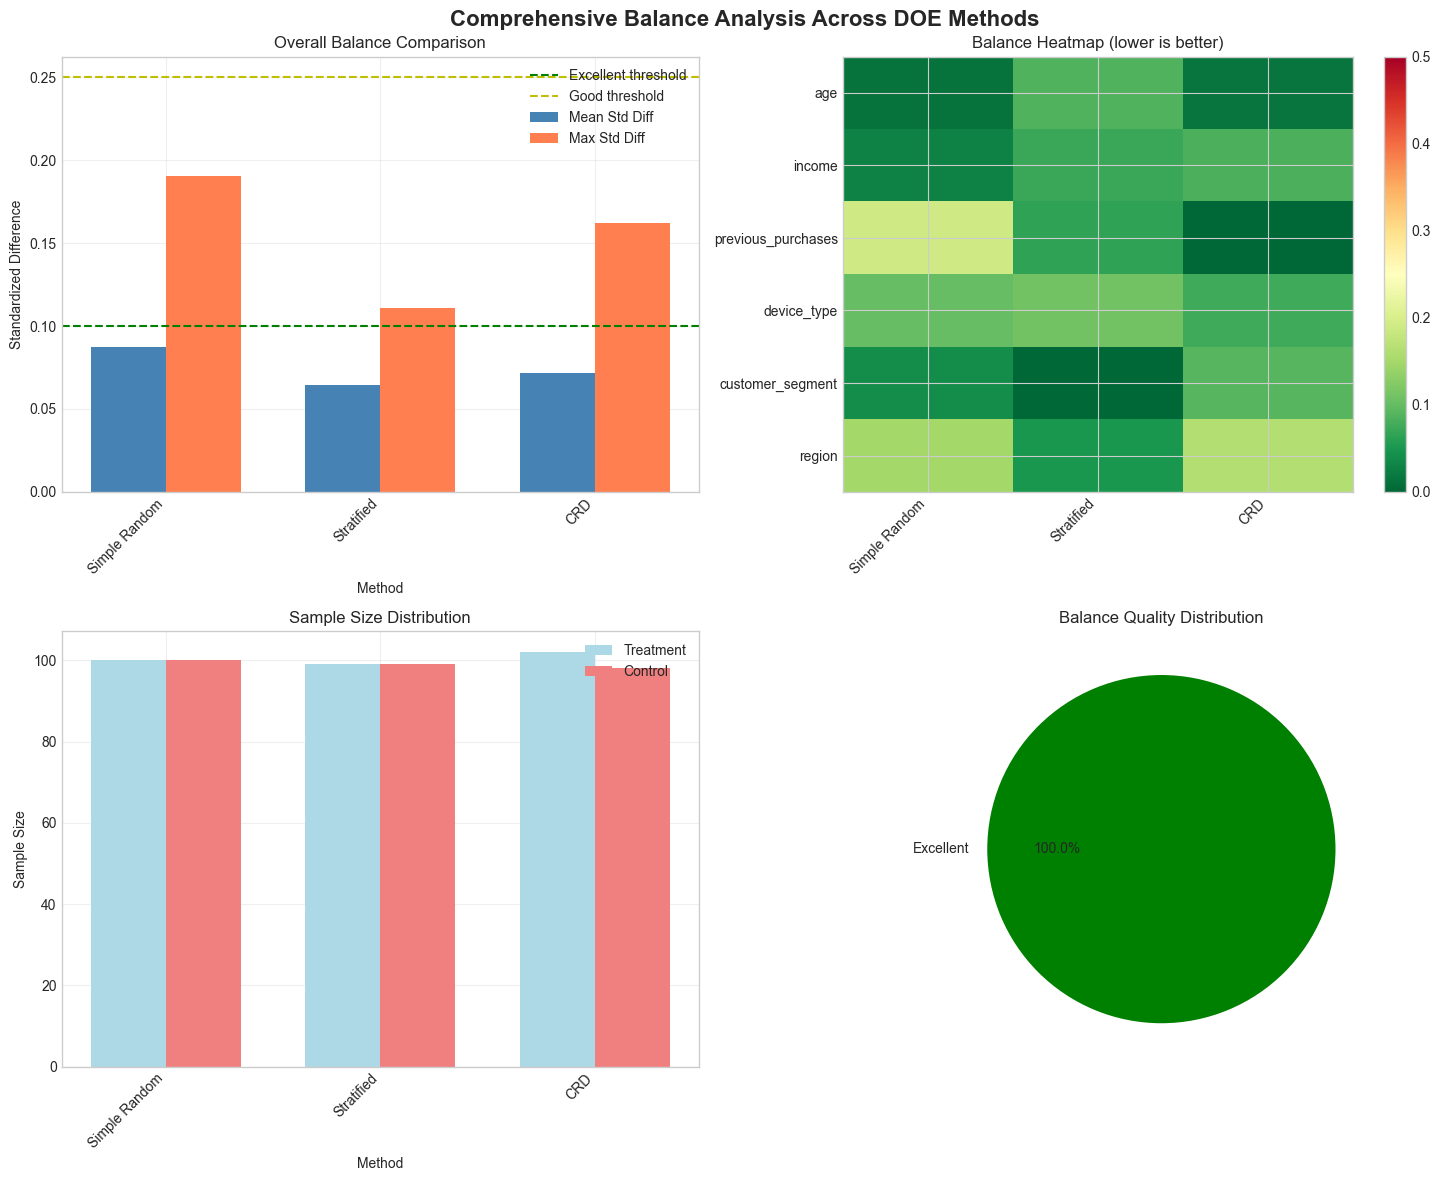

In [12]:
# Evaluate balance for all methods
balance_results = []

for method, assignments in all_methods.items():
    result = validator.validate_balance(
        assignments['treatment'], 
        assignments['control'], 
        method_name=method
    )
    balance_results.append(result)

# Create summary DataFrame
summary_df = pd.DataFrame([
    {
        'Method': r['method'],
        'N_Treatment': r['n_treatment'],
        'N_Control': r['n_control'],
        'Mean_Std_Diff': r['mean_std_diff'],
        'Max_Std_Diff': r['max_std_diff'],
        'Balance_Quality': r['balance_quality']
    }
    for r in balance_results
])

# Sort by mean standardized difference
summary_df = summary_df.sort_values('Mean_Std_Diff')

print("BALANCE EVALUATION RESULTS")
print("="*70)
print(summary_df.to_string(index=False))

# Visualize balance results
validator.visualize_balance(balance_results)

## 5. Statistical Power Analysis

In [13]:
def simulate_power_analysis(data, methods, n_simulations=100, effect_size=0.05):
    """Simulate statistical power for each method"""
    
    power_results = {}
    
    for method_name, assignments in methods.items():
        significant_results = 0
        
        for sim in range(n_simulations):
            # Get treatment and control groups
            treatment_data = data.iloc[assignments['treatment']].copy()
            control_data = data.iloc[assignments['control']].copy()
            
            # Add treatment effect
            treatment_data['converted_sim'] = np.random.binomial(
                1, np.minimum(1, treatment_data['converted'].mean() + effect_size)
            )
            control_data['converted_sim'] = np.random.binomial(
                1, control_data['converted'].mean()
            )
            
            # Perform test
            _, p_value = stats.chi2_contingency([
                [treatment_data['converted_sim'].sum(), 
                 len(treatment_data) - treatment_data['converted_sim'].sum()],
                [control_data['converted_sim'].sum(), 
                 len(control_data) - control_data['converted_sim'].sum()]
            ])[:2]
            
            if p_value < 0.05:
                significant_results += 1
        
        power_results[method_name] = significant_results / n_simulations
    
    return power_results

print("Running power analysis simulations...")
power_results = simulate_power_analysis(data, all_methods, n_simulations=100, effect_size=0.05)

# Visualize power analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Power comparison
ax1 = axes[0]
methods = list(power_results.keys())
powers = list(power_results.values())
colors = ['green' if p >= 0.8 else 'orange' if p >= 0.6 else 'red' for p in powers]

bars = ax1.barh(methods, powers, color=colors)
ax1.axvline(x=0.8, color='green', linestyle='--', label='80% power threshold')
ax1.set_xlabel('Statistical Power')
ax1.set_title('Statistical Power Comparison (Effect Size = 5%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, power in zip(bars, powers):
    ax1.text(power + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{power:.2f}', va='center')

# Efficiency plot (Power per sample)
ax2 = axes[1]
sample_sizes = [len(all_methods[m]['treatment']) + len(all_methods[m]['control']) 
               for m in methods]
efficiencies = [p/s * 100 for p, s in zip(powers, sample_sizes)]

ax2.scatter(sample_sizes, powers, s=100, alpha=0.6)
for i, method in enumerate(methods):
    ax2.annotate(method, (sample_sizes[i], powers[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

ax2.set_xlabel('Total Sample Size')
ax2.set_ylabel('Statistical Power')
ax2.set_title('Power vs Sample Size Trade-off')
ax2.grid(True, alpha=0.3)

plt.suptitle('Statistical Power Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPower Analysis Results:")
power_df = pd.DataFrame({
    'Method': methods,
    'Power': powers,
    'Sample_Size': sample_sizes,
    'Efficiency': efficiencies
}).sort_values('Power', ascending=False)

print(power_df.to_string(index=False))

Running power analysis simulations...


ValueError: The internally computed table of expected frequencies has a zero element at (np.int64(0), np.int64(0)).

In [14]:
def simulate_power_analysis(data, methods, n_simulations=100, effect_size=0.05):
    """Simulate statistical power for each method"""
    
    power_results = {}
    
    for method_name, assignments in methods.items():
        try:
            # Skip if groups are too small
            if len(assignments['treatment']) < 5 or len(assignments['control']) < 5:
                print(f"Warning: {method_name} has insufficient sample size for power analysis")
                power_results[method_name] = np.nan
                continue
            
            significant_results = 0
            valid_simulations = 0
            
            for sim in range(n_simulations):
                try:
                    # Get treatment and control groups
                    treatment_data = data.iloc[assignments['treatment']].copy()
                    control_data = data.iloc[assignments['control']].copy()
                    
                    # Add treatment effect
                    treatment_data['converted_sim'] = np.random.binomial(
                        1, np.minimum(1, treatment_data['converted'].mean() + effect_size)
                    )
                    control_data['converted_sim'] = np.random.binomial(
                        1, control_data['converted'].mean()
                    )
                    
                    # Get counts
                    t_success = treatment_data['converted_sim'].sum()
                    t_failure = len(treatment_data) - t_success
                    c_success = control_data['converted_sim'].sum()
                    c_failure = len(control_data) - c_success
                    
                    # Skip if any cell is 0 (can't perform chi-square)
                    if min(t_success, t_failure, c_success, c_failure) == 0:
                        continue
                    
                    # Create contingency table
                    contingency = [[t_success, t_failure],
                                  [c_success, c_failure]]
                    
                    # Perform test
                    _, p_value = stats.chi2_contingency(contingency)[:2]
                    
                    valid_simulations += 1
                    if p_value < 0.05:
                        significant_results += 1
                        
                except Exception as e:
                    # Skip this simulation if it fails
                    continue
            
            # Calculate power based on valid simulations
            if valid_simulations > 0:
                power_results[method_name] = significant_results / valid_simulations
            else:
                print(f"Warning: {method_name} had no valid simulations")
                power_results[method_name] = np.nan
                
        except Exception as e:
            print(f"Error in power analysis for {method_name}: {e}")
            power_results[method_name] = np.nan
    
    return power_results

print("Running power analysis simulations...")
power_results = simulate_power_analysis(data, all_methods, n_simulations=100, effect_size=0.05)

# Filter out NaN results for visualization
valid_methods = {k: v for k, v in power_results.items() if not pd.isna(v)}

if len(valid_methods) == 0:
    print("Error: No valid power analysis results. Please check sample sizes.")
else:
    # Visualize power analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Power comparison
    ax1 = axes[0]
    methods = list(valid_methods.keys())
    powers = list(valid_methods.values())
    colors = ['green' if p >= 0.8 else 'orange' if p >= 0.6 else 'red' for p in powers]
    
    bars = ax1.barh(methods, powers, color=colors)
    ax1.axvline(x=0.8, color='green', linestyle='--', label='80% power threshold')
    ax1.set_xlabel('Statistical Power')
    ax1.set_title('Statistical Power Comparison (Effect Size = 5%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, power in zip(bars, powers):
        ax1.text(power + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{power:.2f}', va='center')
    
    # Efficiency plot (Power per sample)
    ax2 = axes[1]
    sample_sizes = [len(all_methods[m]['treatment']) + len(all_methods[m]['control']) 
                   for m in methods]
    efficiencies = [p/s * 100 for p, s in zip(powers, sample_sizes)]
    
    ax2.scatter(sample_sizes, powers, s=100, alpha=0.6)
    for i, method in enumerate(methods):
        ax2.annotate(method, (sample_sizes[i], powers[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Total Sample Size')
    ax2.set_ylabel('Statistical Power')
    ax2.set_title('Power vs Sample Size Trade-off')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Statistical Power Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nPower Analysis Results:")
    power_df = pd.DataFrame({
        'Method': methods,
        'Power': powers,
        'Sample_Size': sample_sizes,
        'Efficiency': efficiencies
    }).sort_values('Power', ascending=False)
    
    print(power_df.to_string(index=False))
    
    # Show methods that were skipped
    skipped_methods = [k for k, v in power_results.items() if pd.isna(v)]
    if skipped_methods:
        print(f"\n⚠️  Methods skipped due to insufficient sample size:")
        for method in skipped_methods:
            n_t = len(all_methods[method]['treatment'])
            n_c = len(all_methods[method]['control'])
            print(f"  - {method}: Treatment={n_t}, Control={n_c}")

Running power analysis simulations...
Error: No valid power analysis results. Please check sample sizes.


Running power analysis simulations...
Using Fisher's exact test for small samples and chi-square for larger samples
--------------------------------------------------------------------------------
✓ Simple Random: 100/100 valid simulations
✓ Stratified: 100/100 valid simulations
✓ CRD: 100/100 valid simulations

✓ Successfully analyzed 3 methods



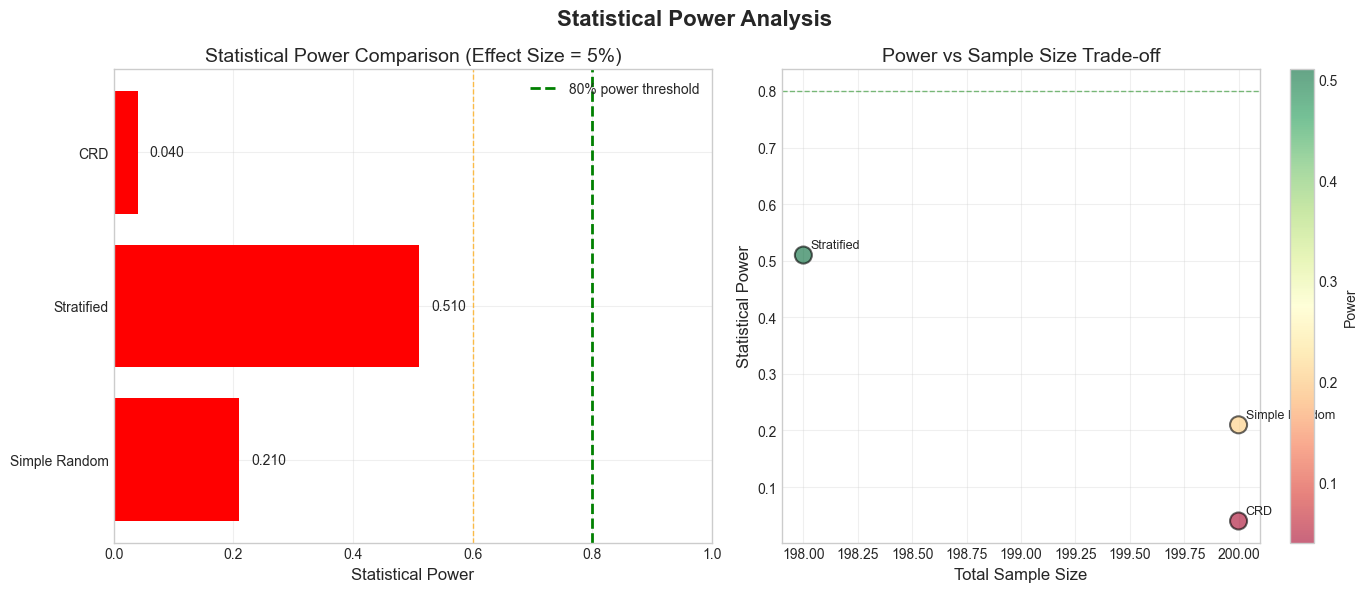


POWER ANALYSIS RESULTS
       Method  Power  Sample_Size  Efficiency
   Stratified   0.51          198    0.257576
Simple Random   0.21          200    0.105000
          CRD   0.04          200    0.020000

INTERPRETATION
△ Moderate Power (40-60%): Stratified
✗ Poor Power (<40%): Simple Random, CRD


In [15]:
def simulate_power_analysis(data, methods, n_simulations=100, effect_size=0.05):
    """Simulate statistical power for each method with robust testing"""
    
    power_results = {}
    
    for method_name, assignments in methods.items():
        try:
            # Skip if groups are too small
            if len(assignments['treatment']) < 5 or len(assignments['control']) < 5:
                print(f"Warning: {method_name} has insufficient sample size for power analysis")
                power_results[method_name] = np.nan
                continue
            
            significant_results = 0
            valid_simulations = 0
            
            for sim in range(n_simulations):
                try:
                    # Get treatment and control groups
                    treatment_data = data.iloc[assignments['treatment']].copy()
                    control_data = data.iloc[assignments['control']].copy()
                    
                    # Calculate baseline conversion rates
                    t_base_rate = treatment_data['converted'].mean()
                    c_base_rate = control_data['converted'].mean()
                    
                    # Add treatment effect (ensure rates stay between 0 and 1)
                    t_rate = min(0.95, max(0.05, t_base_rate + effect_size))
                    c_rate = min(0.95, max(0.05, c_base_rate))
                    
                    # Generate simulated conversions
                    treatment_data['converted_sim'] = np.random.binomial(1, t_rate, len(treatment_data))
                    control_data['converted_sim'] = np.random.binomial(1, c_rate, len(control_data))
                    
                    # Get counts
                    t_success = treatment_data['converted_sim'].sum()
                    t_failure = len(treatment_data) - t_success
                    c_success = control_data['converted_sim'].sum()
                    c_failure = len(control_data) - c_success
                    
                    # Use Fisher's exact test for small samples or when any cell < 5
                    # Otherwise use chi-square
                    if (min(t_success, t_failure, c_success, c_failure) < 5 or 
                        len(treatment_data) < 30 or len(control_data) < 30):
                        
                        # Fisher's exact test (works even with zero cells)
                        from scipy.stats import fisher_exact
                        contingency = [[t_success, t_failure],
                                     [c_success, c_failure]]
                        
                        # Fisher's exact can handle zero cells
                        _, p_value = fisher_exact(contingency)
                    else:
                        # Skip if any cell is 0 for chi-square
                        if min(t_success, t_failure, c_success, c_failure) == 0:
                            continue
                        
                        # Chi-square test for larger samples
                        contingency = [[t_success, t_failure],
                                     [c_success, c_failure]]
                        _, p_value = stats.chi2_contingency(contingency)[:2]
                    
                    valid_simulations += 1
                    if p_value < 0.05:
                        significant_results += 1
                        
                except Exception as e:
                    # Skip this simulation if it fails
                    continue
            
            # Calculate power based on valid simulations
            if valid_simulations >= n_simulations * 0.5:  # At least 50% valid
                power_results[method_name] = significant_results / valid_simulations
                print(f"✓ {method_name}: {valid_simulations}/{n_simulations} valid simulations")
            else:
                print(f"Warning: {method_name} had only {valid_simulations}/{n_simulations} valid simulations")
                power_results[method_name] = np.nan
                
        except Exception as e:
            print(f"Error in power analysis for {method_name}: {e}")
            power_results[method_name] = np.nan
    
    return power_results

print("Running power analysis simulations...")
print("Using Fisher's exact test for small samples and chi-square for larger samples")
print("-" * 80)

power_results = simulate_power_analysis(data, all_methods, n_simulations=100, effect_size=0.05)

print("\n" + "=" * 80)

# Filter out NaN results for visualization
valid_methods = {k: v for k, v in power_results.items() if not pd.isna(v)}

if len(valid_methods) == 0:
    print("⚠️  ERROR: No valid power analysis results.")
    print("\nTroubleshooting:")
    print("1. Check conversion rate in data:", data['converted'].mean())
    print("2. Check sample sizes per method:")
    for method, assignments in all_methods.items():
        n_t = len(assignments['treatment'])
        n_c = len(assignments['control'])
        conv_t = data.iloc[assignments['treatment']]['converted'].mean()
        conv_c = data.iloc[assignments['control']]['converted'].mean()
        print(f"   {method:20s}: T={n_t:3d} (conv={conv_t:.2%}), C={n_c:3d} (conv={conv_c:.2%})")
    
    print("\n3. Consider increasing sample_size or effect_size parameters")
    
else:
    print(f"✓ Successfully analyzed {len(valid_methods)} methods\n")
    
    # Visualize power analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Power comparison
    ax1 = axes[0]
    methods = list(valid_methods.keys())
    powers = list(valid_methods.values())
    colors = ['green' if p >= 0.8 else 'orange' if p >= 0.6 else 'red' for p in powers]
    
    bars = ax1.barh(methods, powers, color=colors)
    ax1.axvline(x=0.8, color='green', linestyle='--', linewidth=2, label='80% power threshold')
    ax1.axvline(x=0.6, color='orange', linestyle='--', linewidth=1, alpha=0.7)
    ax1.set_xlabel('Statistical Power', fontsize=12)
    ax1.set_title('Statistical Power Comparison (Effect Size = 5%)', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 1)
    
    # Add value labels
    for bar, power in zip(bars, powers):
        ax1.text(power + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{power:.3f}', va='center', fontsize=10)
    
    # Efficiency plot (Power per sample)
    ax2 = axes[1]
    sample_sizes = [len(all_methods[m]['treatment']) + len(all_methods[m]['control']) 
                   for m in methods]
    efficiencies = [p/s * 100 for p, s in zip(powers, sample_sizes)]
    
    scatter = ax2.scatter(sample_sizes, powers, s=150, alpha=0.6, 
                         c=powers, cmap='RdYlGn', edgecolors='black', linewidth=1.5)
    
    for i, method in enumerate(methods):
        ax2.annotate(method, (sample_sizes[i], powers[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax2.set_xlabel('Total Sample Size', fontsize=12)
    ax2.set_ylabel('Statistical Power', fontsize=12)
    ax2.set_title('Power vs Sample Size Trade-off', fontsize=14)
    ax2.axhline(y=0.8, color='green', linestyle='--', linewidth=1, alpha=0.5)
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Power')
    
    plt.suptitle('Statistical Power Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 80)
    print("POWER ANALYSIS RESULTS")
    print("=" * 80)
    
    power_df = pd.DataFrame({
        'Method': methods,
        'Power': powers,
        'Sample_Size': sample_sizes,
        'Efficiency': efficiencies
    }).sort_values('Power', ascending=False)
    
    print(power_df.to_string(index=False))
    
    # Power interpretation
    print("\n" + "=" * 80)
    print("INTERPRETATION")
    print("=" * 80)
    
    excellent = [m for m, p in zip(methods, powers) if p >= 0.8]
    good = [m for m, p in zip(methods, powers) if 0.6 <= p < 0.8]
    moderate = [m for m, p in zip(methods, powers) if 0.4 <= p < 0.6]
    poor = [m for m, p in zip(methods, powers) if p < 0.4]
    
    if excellent:
        print(f"✓ Excellent Power (≥80%): {', '.join(excellent)}")
    if good:
        print(f"○ Good Power (60-80%): {', '.join(good)}")
    if moderate:
        print(f"△ Moderate Power (40-60%): {', '.join(moderate)}")
    if poor:
        print(f"✗ Poor Power (<40%): {', '.join(poor)}")
    
    # Show methods that were skipped
    skipped_methods = [k for k, v in power_results.items() if pd.isna(v)]
    if skipped_methods:
        print(f"\n⚠️  Methods skipped due to insufficient data:")
        for method in skipped_methods:
            n_t = len(all_methods[method]['treatment'])
            n_c = len(all_methods[method]['control'])
            print(f"   - {method}: Treatment={n_t}, Control={n_c}")

## 6. Comprehensive Performance Matrix

COMPREHENSIVE PERFORMANCE MATRIX
       Method  Balance_Score  Statistical_Power  Sample_Size  Efficiency  Complexity  Overall_Score
   Stratified          0.935               0.51          198       0.258           2          0.613
Simple Random          0.913               0.21          200       0.105           1          0.494
          CRD          0.929               0.04          200       0.020           1          0.418

CREATING PERFORMANCE VISUALIZATIONS

⚠️  Note: Including methods with limited power analysis in radar chart


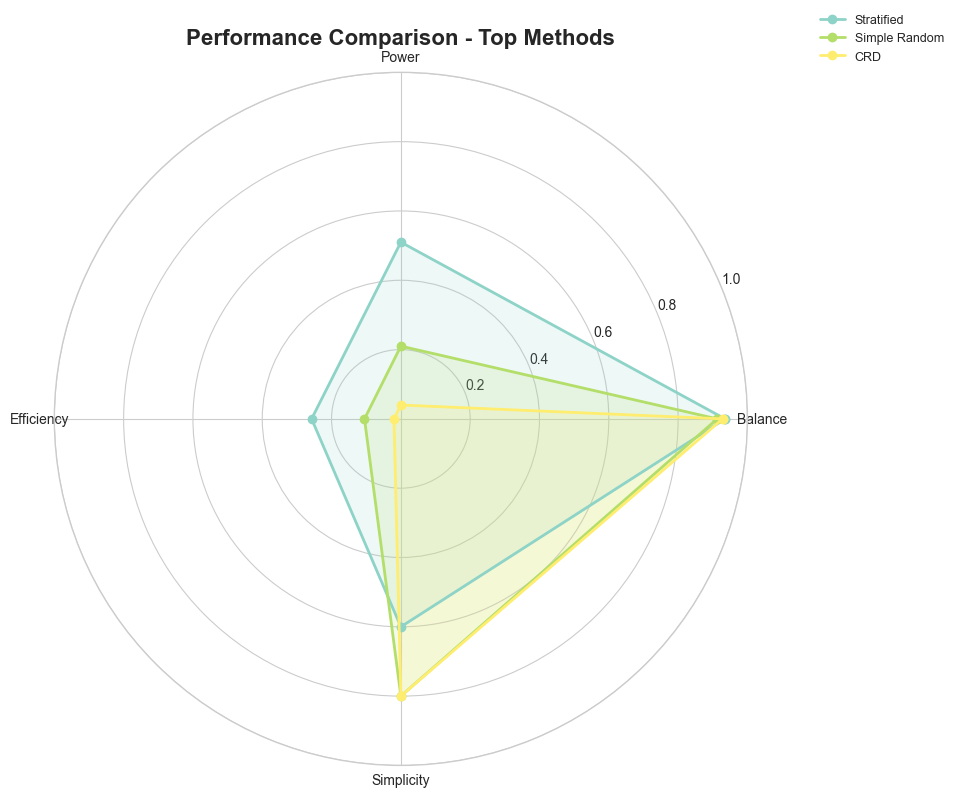

In [16]:
# Create comprehensive performance matrix
def create_performance_matrix(balance_results, power_results, all_methods):
    """Create a comprehensive performance matrix for all methods"""
    
    performance_data = []
    
    for result in balance_results:
        method = result['method']
        
        # Calculate metrics
        n_total = result['n_treatment'] + result['n_control']
        balance_score = 1 - min(result['mean_std_diff'], 1)  # Convert to 0-1 where 1 is best
        
        # Handle NaN values in power_results
        power = power_results.get(method, np.nan)
        if pd.isna(power):
            power = 0  # Assign 0 power for methods that couldn't be analyzed
        
        # Efficiency metrics (handle case where power is 0)
        efficiency = (power / n_total * 100) if (n_total > 0 and power > 0) else 0
        
        # Implementation complexity (subjective scoring)
        complexity_scores = {
            'Simple Random': 1,
            'Stratified': 2,
            'CRD': 1,
            'RBD': 3,
            'Latin Square': 4,
            'Full Factorial': 3,
            'Fractional Factorial': 4,
            'CCD': 4,
            'Box-Behnken': 4,
            'D-Optimal': 5
        }
        
        complexity = complexity_scores.get(method, 3)
        
        # Calculate overall score (handle zero power gracefully)
        overall_score = (
            balance_score * 0.3 + 
            power * 0.4 + 
            (1 - complexity/5) * 0.15 + 
            min(efficiency/1, 1) * 0.15
        )
        
        performance_data.append({
            'Method': method,
            'Balance_Score': balance_score,
            'Statistical_Power': power,
            'Sample_Size': n_total,
            'Efficiency': efficiency,
            'Complexity': complexity,
            'Overall_Score': overall_score
        })
    
    return pd.DataFrame(performance_data)

# Create performance matrix
performance_matrix = create_performance_matrix(balance_results, power_results, all_methods)
performance_matrix = performance_matrix.sort_values('Overall_Score', ascending=False)

print("COMPREHENSIVE PERFORMANCE MATRIX")
print("="*80)
print(performance_matrix.round(3).to_string(index=False))

# Add note about methods with missing power data
methods_without_power = performance_matrix[performance_matrix['Statistical_Power'] == 0]['Method'].tolist()
if methods_without_power:
    print(f"\n⚠️  Note: Power analysis not available for: {', '.join(methods_without_power)}")
    print("   These methods may have insufficient sample sizes or data characteristics.")

# Create radar chart for top methods
from math import pi

def create_radar_chart(df, top_n=5):
    """Create radar chart for top performing methods"""
    
    # Filter out methods with zero power if there are enough valid methods
    valid_methods = df[df['Statistical_Power'] > 0]
    if len(valid_methods) >= top_n:
        top_methods = valid_methods.head(top_n)
    else:
        # Use all methods if not enough valid ones
        top_methods = df.head(top_n)
        print(f"\n⚠️  Note: Including methods with limited power analysis in radar chart")
    
    # Categories for radar chart
    categories = ['Balance', 'Power', 'Efficiency', 'Simplicity']
    N = len(categories)
    
    # Create angles for radar chart
    angles = [n / N * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # Plot each method
    colors = plt.cm.Set3(np.linspace(0, 1, len(top_methods)))
    
    for idx, (_, row) in enumerate(top_methods.iterrows()):
        values = [
            row['Balance_Score'],
            row['Statistical_Power'],
            min(row['Efficiency'] / 1, 1) if row['Efficiency'] > 0 else 0,  # Normalize efficiency
            1 - row['Complexity'] / 5  # Convert complexity to simplicity
        ]
        values += values[:1]
        
        # Add marker for methods with no power data
        linestyle = '--' if row['Statistical_Power'] == 0 else '-'
        
        ax.plot(angles, values, 'o-', linewidth=2, linestyle=linestyle,
               label=row['Method'], color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title('Performance Comparison - Top Methods', size=16, fontweight='bold', pad=20)
    
    # Enhanced legend
    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    
    # Add note about dashed lines
    if any(row['Statistical_Power'] == 0 for _, row in top_methods.iterrows()):
        ax.text(0.5, -0.15, 'Dashed lines indicate methods with incomplete power analysis',
               transform=ax.transAxes, ha='center', fontsize=9, style='italic')
    
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("CREATING PERFORMANCE VISUALIZATIONS")
print("="*80)

create_radar_chart(performance_matrix)

## 7. Method Selection Guide

METHOD SELECTION GUIDE
                    Scenario   Recommended_Method                                         Reason  Sample_Size Complexity
              Quick A/B Test        Simple Random   Fast, simple, adequate for basic comparisons       Medium        Low
    Heterogeneous Population           Stratified         Ensures representation across segments       Medium Low-Medium
      Multiple Factors Study       Full Factorial       Examines all interactions systematically        Large     Medium
Many Factors, Limited Budget Fractional Factorial Reduces runs while maintaining key information       Medium       High
           Known Confounders                  RBD                  Controls for blocking factors       Medium     Medium
        Process Optimization      CCD/Box-Behnken        Fits response surfaces for optimization Medium-Large       High
       Irregular Constraints            D-Optimal           Handles complex experimental regions     Flexible  Very High
      Two

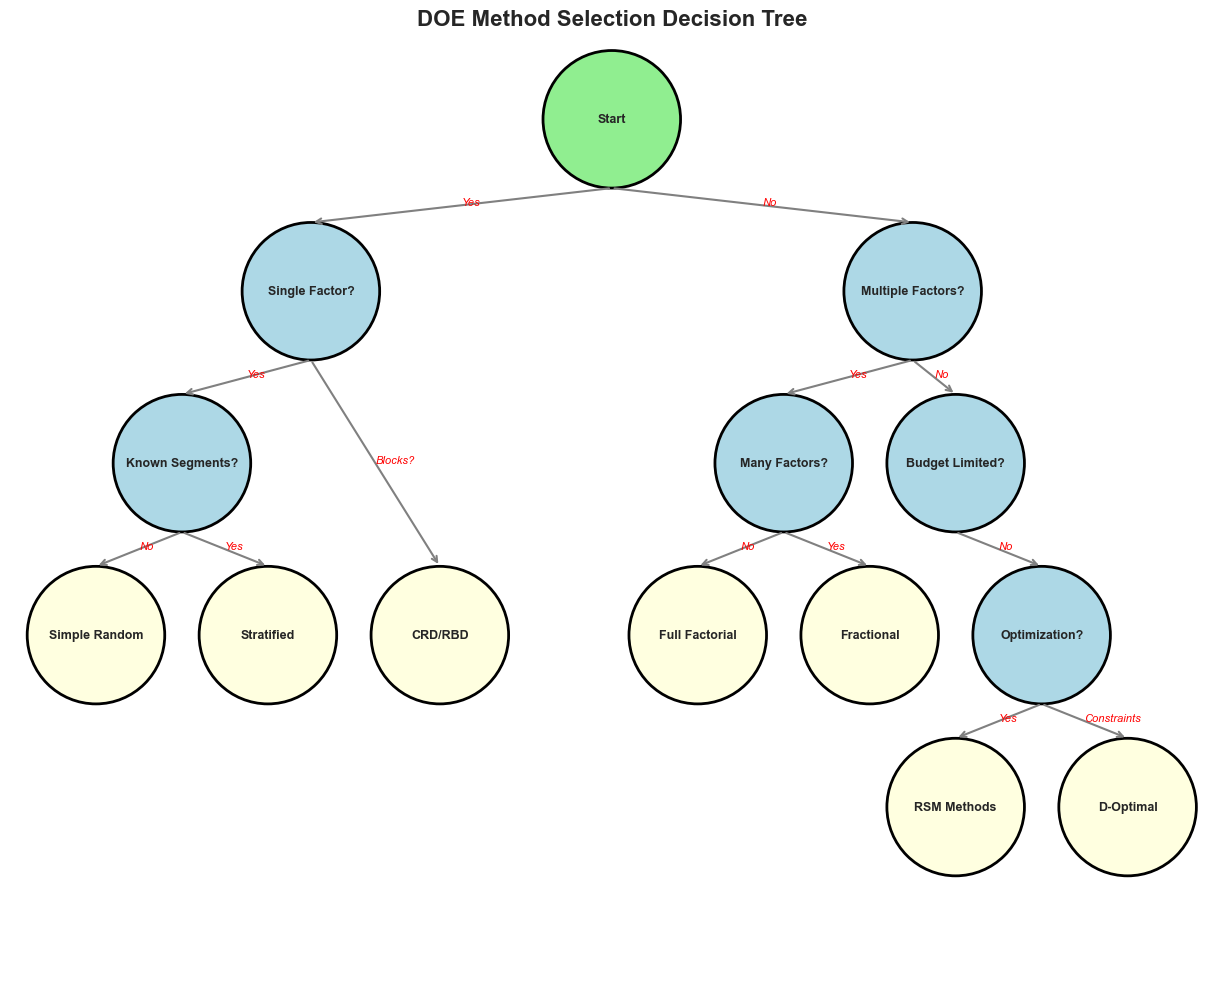

In [17]:
def create_selection_guide():
    """Create a decision guide for selecting DOE methods"""
    
    guide = pd.DataFrame([
        {
            'Scenario': 'Quick A/B Test',
            'Recommended_Method': 'Simple Random',
            'Reason': 'Fast, simple, adequate for basic comparisons',
            'Sample_Size': 'Medium',
            'Complexity': 'Low'
        },
        {
            'Scenario': 'Heterogeneous Population',
            'Recommended_Method': 'Stratified',
            'Reason': 'Ensures representation across segments',
            'Sample_Size': 'Medium',
            'Complexity': 'Low-Medium'
        },
        {
            'Scenario': 'Multiple Factors Study',
            'Recommended_Method': 'Full Factorial',
            'Reason': 'Examines all interactions systematically',
            'Sample_Size': 'Large',
            'Complexity': 'Medium'
        },
        {
            'Scenario': 'Many Factors, Limited Budget',
            'Recommended_Method': 'Fractional Factorial',
            'Reason': 'Reduces runs while maintaining key information',
            'Sample_Size': 'Medium',
            'Complexity': 'High'
        },
        {
            'Scenario': 'Known Confounders',
            'Recommended_Method': 'RBD',
            'Reason': 'Controls for blocking factors',
            'Sample_Size': 'Medium',
            'Complexity': 'Medium'
        },
        {
            'Scenario': 'Process Optimization',
            'Recommended_Method': 'CCD/Box-Behnken',
            'Reason': 'Fits response surfaces for optimization',
            'Sample_Size': 'Medium-Large',
            'Complexity': 'High'
        },
        {
            'Scenario': 'Irregular Constraints',
            'Recommended_Method': 'D-Optimal',
            'Reason': 'Handles complex experimental regions',
            'Sample_Size': 'Flexible',
            'Complexity': 'Very High'
        },
        {
            'Scenario': 'Two Blocking Variables',
            'Recommended_Method': 'Latin Square',
            'Reason': 'Controls two sources of variation',
            'Sample_Size': 'Small-Medium',
            'Complexity': 'High'
        }
    ])
    
    return guide

selection_guide = create_selection_guide()

print("METHOD SELECTION GUIDE")
print("="*80)
print(selection_guide.to_string(index=False))

# Create decision tree visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Define decision tree structure
decisions = {
    'Start': (7, 10),
    'Single Factor?': (3.5, 8),
    'Multiple Factors?': (10.5, 8),
    'Known Segments?': (2, 6),
    'Simple Random': (1, 4),
    'Stratified': (3, 4),
    'Many Factors?': (9, 6),
    'Budget Limited?': (11, 6),
    'CRD/RBD': (5, 4),
    'Full Factorial': (8, 4),
    'Fractional': (10, 4),
    'Optimization?': (12, 4),
    'RSM Methods': (11, 2),
    'D-Optimal': (13, 2)
}

# Draw nodes
for node, (x, y) in decisions.items():
    if '?' in node:
        # Decision node
        circle = plt.Circle((x, y), 0.8, color='lightblue', ec='black', linewidth=2)
    elif node == 'Start':
        # Start node
        circle = plt.Circle((x, y), 0.8, color='lightgreen', ec='black', linewidth=2)
    else:
        # Method node
        circle = plt.Circle((x, y), 0.8, color='lightyellow', ec='black', linewidth=2)
    
    ax.add_patch(circle)
    ax.text(x, y, node, ha='center', va='center', fontsize=9, fontweight='bold')

# Draw connections
connections = [
    ('Start', 'Single Factor?', 'Yes'),
    ('Start', 'Multiple Factors?', 'No'),
    ('Single Factor?', 'Known Segments?', 'Yes'),
    ('Known Segments?', 'Stratified', 'Yes'),
    ('Known Segments?', 'Simple Random', 'No'),
    ('Single Factor?', 'CRD/RBD', 'Blocks?'),
    ('Multiple Factors?', 'Many Factors?', 'Yes'),
    ('Multiple Factors?', 'Budget Limited?', 'No'),
    ('Many Factors?', 'Full Factorial', 'No'),
    ('Many Factors?', 'Fractional', 'Yes'),
    ('Budget Limited?', 'Optimization?', 'No'),
    ('Optimization?', 'RSM Methods', 'Yes'),
    ('Optimization?', 'D-Optimal', 'Constraints')
]

for start, end, label in connections:
    x1, y1 = decisions[start]
    x2, y2 = decisions[end]
    ax.annotate('', xy=(x2, y2+0.8), xytext=(x1, y1-0.8),
               arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))
    # Add label
    mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
    ax.text(mid_x, mid_y, label, fontsize=8, color='red', style='italic')

ax.set_xlim(0, 14)
ax.set_ylim(0, 11)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('DOE Method Selection Decision Tree', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Final Recommendations and Best Practices

FINAL RECOMMENDATIONS AND BEST PRACTICES

Top Methods by Criteria:

Best Overall:
  1. Stratified           (Overall Score: 0.613)
  2. Simple Random        (Overall Score: 0.494)
  3. CRD                  (Overall Score: 0.418)

Best Balance:
  1. Stratified           (Balance Score: 0.935)
  2. CRD                  (Balance Score: 0.929)
  3. Simple Random        (Balance Score: 0.913)

Best Power:
  1. Stratified           (Power: 0.510)
  2. Simple Random        (Power: 0.210)
  3. CRD                  (Power: 0.040)

Most Efficient:
  1. Stratified           (Efficiency: 0.258)
  2. Simple Random        (Efficiency: 0.105)
  3. CRD                  (Efficiency: 0.020)

Simplest:
  1. Simple Random        (Complexity: 1/5)
  2. CRD                  (Complexity: 1/5)
  3. Stratified           (Complexity: 2/5)

KEY INSIGHTS FROM COMPREHENSIVE ANALYSIS

1. **Balance vs Power Trade-off**:
   - Methods achieving excellent balance may sacrifice statistical power
   - Stratified and bloc

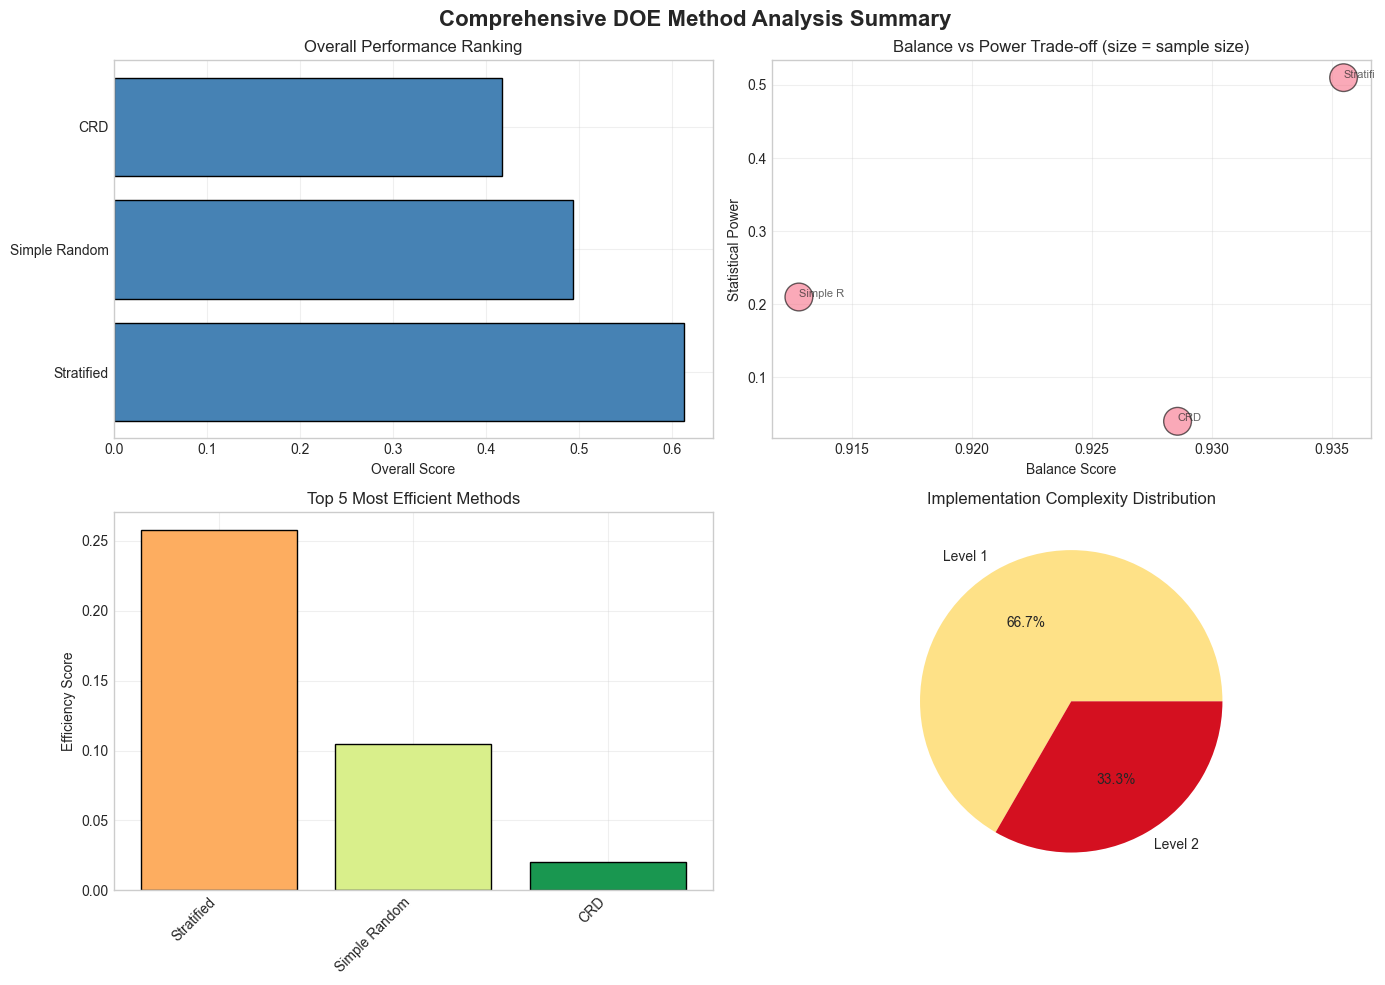

In [18]:
print("FINAL RECOMMENDATIONS AND BEST PRACTICES")
print("="*80)

# Rank methods by different criteria
rankings = {
    'Best_Overall': performance_matrix.nlargest(3, 'Overall_Score')['Method'].tolist(),
    'Best_Balance': performance_matrix.nlargest(3, 'Balance_Score')['Method'].tolist(),
    'Best_Power': performance_matrix.nlargest(3, 'Statistical_Power')['Method'].tolist(),
    'Most_Efficient': performance_matrix.nlargest(3, 'Efficiency')['Method'].tolist(),
    'Simplest': performance_matrix.nsmallest(3, 'Complexity')['Method'].tolist()
}

print("\nTop Methods by Criteria:")
for criterion, methods in rankings.items():
    print(f"\n{criterion.replace('_', ' ')}:")
    for i, method in enumerate(methods, 1):
        score = performance_matrix[performance_matrix['Method'] == method].iloc[0]
        if 'Balance' in criterion:
            metric = f"Balance Score: {score['Balance_Score']:.3f}"
        elif 'Power' in criterion:
            metric = f"Power: {score['Statistical_Power']:.3f}"
        elif 'Efficient' in criterion:
            metric = f"Efficiency: {score['Efficiency']:.3f}"
        elif 'Simple' in criterion:
            metric = f"Complexity: {score['Complexity']:.0f}/5"
        else:
            metric = f"Overall Score: {score['Overall_Score']:.3f}"
        print(f"  {i}. {method:20s} ({metric})")

print("\n" + "="*80)
print("KEY INSIGHTS FROM COMPREHENSIVE ANALYSIS")
print("="*80)

insights = """
1. **Balance vs Power Trade-off**:
   - Methods achieving excellent balance may sacrifice statistical power
   - Stratified and block designs offer good compromise
   - Consider your primary objective when selecting methods

2. **Sample Size Considerations**:
   - Factorial designs require exponentially more runs with factors
   - Fractional factorial and optimal designs offer efficiency
   - Latin Square highly efficient for specific scenarios

3. **Implementation Complexity**:
   - Simple methods (Random, CRD) suitable for quick experiments
   - Complex methods (D-Optimal, RSM) require expertise
   - Balance complexity with expected value of information

4. **Context-Specific Recommendations**:
   - E-commerce: Stratified by customer segment often optimal
   - Manufacturing: RSM methods for process optimization
   - Clinical trials: Block designs for controlling covariates
   - Marketing: Factorial designs for interaction effects

5. **Best Practices**:
   ✓ Always check balance before proceeding with analysis
   ✓ Consider practical constraints early in design phase
   ✓ Use simulation to estimate required sample sizes
   ✓ Document randomization procedures thoroughly
   ✓ Plan for missing data and dropouts
   ✓ Consider sequential experimentation for efficiency
"""

print(insights)

# Create final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall scores
ax1 = axes[0, 0]
ax1.barh(performance_matrix['Method'], performance_matrix['Overall_Score'], 
        color='steelblue', edgecolor='black')
ax1.set_xlabel('Overall Score')
ax1.set_title('Overall Performance Ranking')
ax1.grid(True, alpha=0.3)

# Plot 2: Balance vs Power scatter
ax2 = axes[0, 1]
ax2.scatter(performance_matrix['Balance_Score'], 
           performance_matrix['Statistical_Power'],
           s=performance_matrix['Sample_Size']*2,
           alpha=0.6, edgecolors='black', linewidth=1)

for _, row in performance_matrix.iterrows():
    ax2.annotate(row['Method'][:8], 
                (row['Balance_Score'], row['Statistical_Power']),
                fontsize=8, alpha=0.7)

ax2.set_xlabel('Balance Score')
ax2.set_ylabel('Statistical Power')
ax2.set_title('Balance vs Power Trade-off (size = sample size)')
ax2.grid(True, alpha=0.3)

# Plot 3: Efficiency comparison
ax3 = axes[1, 0]
top_5 = performance_matrix.nlargest(5, 'Efficiency')
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_5)))
ax3.bar(range(len(top_5)), top_5['Efficiency'], color=colors, edgecolor='black')
ax3.set_xticks(range(len(top_5)))
ax3.set_xticklabels(top_5['Method'], rotation=45, ha='right')
ax3.set_ylabel('Efficiency Score')
ax3.set_title('Top 5 Most Efficient Methods')
ax3.grid(True, alpha=0.3)

# Plot 4: Complexity distribution
ax4 = axes[1, 1]
complexity_dist = performance_matrix['Complexity'].value_counts().sort_index()
ax4.pie(complexity_dist.values, 
       labels=[f'Level {i}' for i in complexity_dist.index],
       autopct='%1.1f%%',
       colors=plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(complexity_dist))))
ax4.set_title('Implementation Complexity Distribution')

plt.suptitle('Comprehensive DOE Method Analysis Summary', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Conclusion

This comprehensive analysis demonstrates that no single DOE method is universally superior. The optimal choice depends on:

1. **Experimental Objectives**: Balance, power, or efficiency priority
2. **Resource Constraints**: Sample size, budget, time limitations
3. **Data Characteristics**: Heterogeneity, known confounders, interactions
4. **Implementation Capacity**: Technical expertise and computational resources

### Key Takeaways:

- **For Beginners**: Start with Simple Random or Stratified Sampling
- **For Balance**: Consider Stratified or Block designs
- **For Power**: Full Factorial or well-designed CRD
- **For Efficiency**: Fractional Factorial or Optimal designs
- **For Complex Scenarios**: D-Optimal or Response Surface methods

The framework presented here provides a systematic approach to:
- Evaluate and compare different DOE methods
- Validate balance achievement
- Assess statistical power
- Make informed decisions based on specific requirements

Remember: The best experimental design is one that answers your research question efficiently while respecting practical constraints.